## Elephant: Wavelet Power Spectrum Bias Correction Test

Wavelet power spectra biased to underestimate power of higher frequency components of underlying time series [1]. The bias can be compenstated for by dividing power by the corresponding scale. Testing to see whether simplying multiplying by frequency works on test signal of four sine waves of different frequencies.

[1] Lui Y., Liang X.S. and Weisberg R.H. (2007) Rectification of the bias in the wavelet power spectrum. Journal of Atmospheric and Oceanic Technology 24: 2093-2102. 

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from scipy import fftpack

import neo
from quantities import Hz, mV, sec, ms
from elephant import signal_processing

%matplotlib notebook

/home/julianb/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def fft_power_spectrum(signal, fs):
    X = fftpack.fft(signal)
    ff = fftpack.fftfreq(len(signal)) * fs
    return ff, np.abs(X)**2

def plot_fft(freqs, fftpow, flims=(0,120)):
    plt.plot(freqs, fftpow,'k-')
    plt.xlabel('frequency (Hz)')
    plt.ylabel('power')
    plt.xlim(flims)
    plt.title('FFT power spectrum')
    

def cwt(signal, f0=1.0, f1=120.0, df=1.0):
    freqs=np.arange(f0,f1,df)
    cfs = signal_processing.wavelet_transform(rec, freqs)
    cfs_power = np.squeeze((abs(cfs.T)) ** 2)
    gws_power = np.mean(cfs_power,axis=1)
    return freqs, cfs_power, gws_power
    
def cwt_rectified(signal, f0=1.0, f1=120.0, df=1.0):
    freqs=np.arange(f0,f1,df)
    cfs = signal_processing.wavelet_transform(rec, freqs, zero_padding=True)   
    cfs_power = freqs.reshape(len(freqs),1)*np.squeeze((abs(cfs.T)) ** 2)
    gws_power = np.mean(cfs_power,axis=1)
    return freqs, cfs_power, gws_power    
    
    
    
def plot_cwt(t, freqs, cwt_power, gws_power):
    fmin = min(freqs)
    fmax = max(freqs)
    tmin = t.min()
    tmax = t.max()
    extent = [tmin, tmax, fmin, fmax]
    fig, (ax1, ax2) = plt.subplots(1,2,sharey=True)
    cf = ax1.imshow(cwt_power, aspect='auto', vmin=cwt_power.min(), vmax=cwt_power.max(), extent=extent, origin='lower', cmap='jet')
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('frequency (Hz)')
    ax1.set_title('morlet wavelet transform')
    ax2.plot(gws_power, freqs, 'k-')
    ax2.set_xlabel('time-averaged power')
    ax2.set_title('global wavelet spectrum')
    ax2.set_ylim(freqs[0],freqs[-1])
    
    

Test signal of 4, 14, 30 and 100 Hz consequtive (non-overlapping) sine waves:

In [3]:
def test_sig(f1=4.0, f2=14.0, f3=30.0, f4=100.0):
    fs = 5000.0
    t = np.arange(0.0,4.0,1.0/fs)
    s = 0.1*np.random.normal(size=len(t))
    s[0:5000] += np.sin(2.0*np.pi*f1*t[0:5000])
    s[5000:10000] += np.sin(2.0*np.pi*f2*t[0:5000])
    s[10000:15000] += np.sin(2.0*np.pi*f3*t[0:5000])
    s[15000:20000] += np.sin(2.0*np.pi*f4*t[0:5000])
    return t, s, fs

In [4]:
tt, ss, fss = test_sig()
ss.shape, fss

((20000,), 5000.0)

In [5]:
rec = neo.AnalogSignal(ss, sampling_rate=fss*Hz, units='mV')
rec

AnalogSignal with 1 channels of length 20000; units mV; datatype float64 
sampling rate: 5000.0
time: 0.0 to 4.0

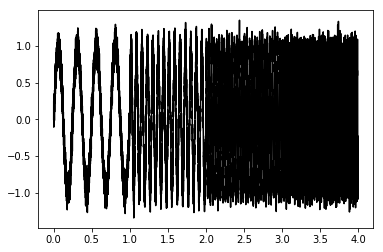

In [6]:
plt.plot(tt, ss, 'k-');


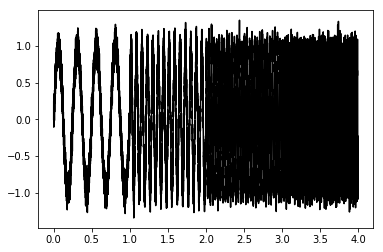

In [7]:
plt.plot(rec.times, rec.magnitude, 'k-');

FFT power spectrum shows power of each frequency component is similar:

In [8]:
ff, fftpower = fft_power_spectrum(ss, fss)

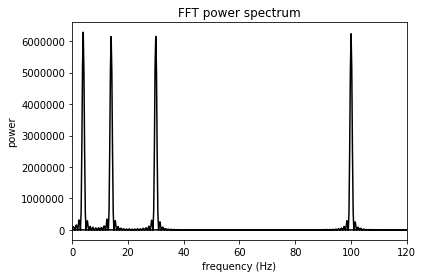

In [9]:
plot_fft(ff, fftpower)

But global wavelet spectrum using existing Elephant function shows power of each frequency component decreasing with frequency (bias):

In [10]:
freq, c, g = cwt(rec)

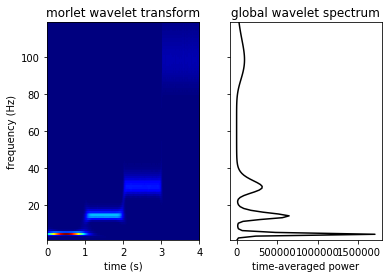

In [11]:
plot_cwt(tt, freq, c, g)

Multiplying by frequency makes power more equal but exceeds FFT power and increases with frequency

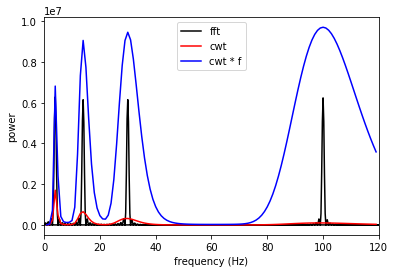

In [12]:
plt.plot(ff, fftpower,'k-', label='fft')
plt.plot(freq, g, 'r-', label='cwt')
plt.plot(freq, g*freq, 'b-', label='cwt * f')
plt.xlim(0,120)
plt.xlabel('frequency (Hz)')
plt.ylabel('power')
plt.legend(loc='best');

Closer look shows multiplying by frequency gives close match to FFT power for 4 Hz but about 30% greater for 14 Hz component:

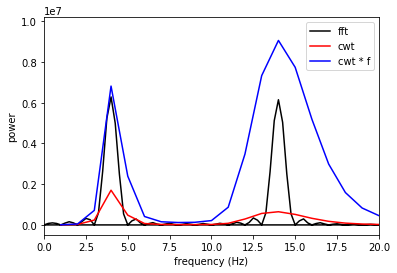

In [13]:
plt.plot(ff, fftpower,'k-', label='fft')
plt.plot(freq, g, 'r-', label='cwt')
plt.plot(freq, g*freq, 'b-', label='cwt * f')
plt.xlim(0,20)
plt.xlabel('frequency (Hz)')
plt.ylabel('power')
plt.legend(loc='best');

In [14]:
gg = (freq*g).reshape(len(g),1)
gg.shape

(119, 1)

In [15]:
c.shape

(119, 20000)

In [16]:
cg = freq.reshape(len(freq),1)*c

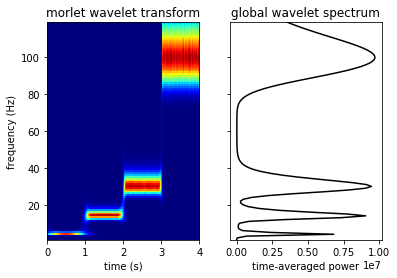

In [17]:
plot_cwt(tt, freq, cg, gg)

In [18]:
ff[100]-ff[99]

0.24999999999999645

In [19]:
freqr, cr, gr, = cwt_rectified(rec,df=0.25)

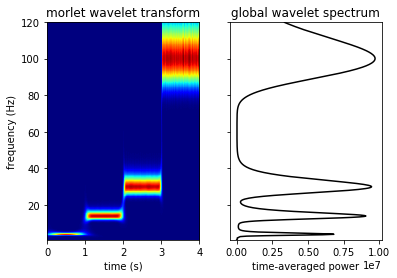

In [20]:
plot_cwt(tt, freqr, cr, gr)

In [21]:
n = 2 ** (int(np.log2(len(ss))) + 1)
n

32768

Examine existing morlet wavelet used in Elephant for 4, 14, 30 and 100 Hz:

In [22]:
def elephant_morlet_wavelet_ft(freq, nco, fs, n):
    # Generate the Fourier transform of Morlet wavelet as defined
    # in Le van Quyen et al. J Neurosci Meth 111:83-98 (2001).
    sigma = nco / (6. * freq)
    freqs = np.fft.fftfreq(n, 1.0 / fs)
    heaviside = np.array(freqs > 0., dtype=np.float)
    ft_real = np.sqrt(2 * np.pi * freq) * sigma * np.exp(-2 * (np.pi * sigma * (freqs - freq)) ** 2) * heaviside * fs
    ft_imag = np.zeros_like(ft_real)
    return ft_real + 1.0j * ft_imag

In frequency domain wavelets decrease in amplitude with frequency (bias): 

(0, 120)

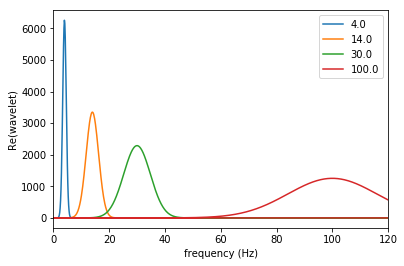

In [23]:
flist = [4.0, 14.0, 30.0, 100.0]
wavef = np.fft.fftfreq(n, 1.0 / fss)
wavelets = np.empty([len(flist), n], dtype=np.complex)
for i, f in enumerate(flist):
        wavelets[i] = elephant_morlet_wavelet_ft(f, 6.0, fss, n)

for i, f in enumerate(flist):
    plt.plot(wavef,np.abs(wavelets[i, :]),'-', label=str(f))
plt.legend(loc='best')
plt.ylabel('Re(wavelet)')
plt.xlabel('frequency (Hz)')
plt.xlim(0,120)

Multiplying by sqrt of frequency compensates for bias (this appears to be used in Le van Quyen et al (2001) equation for wavelet):

(0, 120)

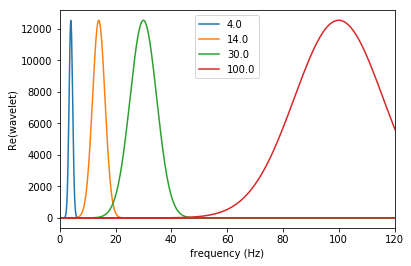

In [24]:
for i, f in enumerate(flist):
    plt.plot(wavef,np.sqrt(f)*np.abs(wavelets[i, :]),'-', label=str(f))
plt.legend(loc='best')
plt.ylabel('Re(wavelet)')
plt.xlabel('frequency (Hz)')
plt.xlim(0,120)

Lets try editing Elephant morlet wavelet function to multiply by sqrt of frequency to see what happens:

In [25]:
def elephant_morlet_wavelet_ft_edited(freq, nco, fs, n):
    # Generate the Fourier transform of Morlet wavelet as defined
    # in Le van Quyen et al. J Neurosci Meth 111:83-98 (2001).
    sigma = nco / (6. * freq)
    freqs = np.fft.fftfreq(n, 1.0 / fs)
    heaviside = np.array(freqs > 0., dtype=np.float)
    ft_real = np.sqrt(freq) * np.sqrt(2 * np.pi * freq) * sigma * np.exp(-2 * (np.pi * sigma * (freqs - freq)) ** 2) * heaviside * fs
    ft_imag = np.zeros_like(ft_real)
    return ft_real + 1.0j * ft_imag

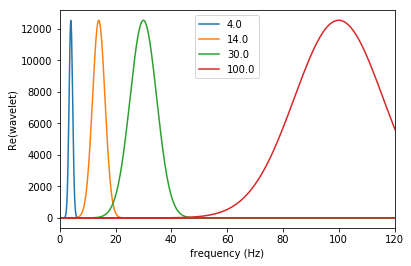

In [26]:
wavelets2 = np.empty([len(flist), n], dtype=np.complex)
for i, f in enumerate(flist):
        wavelets2[i] = elephant_morlet_wavelet_ft_edited(f, 6.0, fss, n)

for i, f in enumerate(flist):
    plt.plot(wavef,np.abs(wavelets2[i, :]),'-', label=str(f))
plt.legend(loc='best')
plt.ylabel('Re(wavelet)')
plt.xlabel('frequency (Hz)')
plt.xlim(0,120);

Now edit Elephant function to see if this compensates for fixed bias in wavelet transform spectrogram:

In [27]:
def wavelet_transform_edited(signal, freq, nco=6.0, fs=1.0, zero_padding=True):
    """
    Compute the wavelet transform of a given signal with Morlet mother wavelet.
    The parametrization of the wavelet is based on [1].

    Parameters
    ----------
    signal : neo.AnalogSignal or array_like
        Time series data to be wavelet-transformed. When multi-dimensional
        array_like is given, the time axis must be the last dimension of
        the array_like.
    freq : float or list of floats
        Center frequency of the Morlet wavelet in Hz. Multiple center
        frequencies can be given as a list, in which case the function
        computes the wavelet transforms for all the given frequencies at once.
    nco : float (optional)
        Size of the mother wavelet (approximate number of oscillation cycles
        within a wavelet; related to the wavelet number w as w ~ 2 pi nco / 6),
        as defined in [1]. A larger nco value leads to a higher frequency
        resolution and a lower temporal resolution, and vice versa. Typically
        used values are in a range of 3 - 8, but one should be cautious when
        using a value smaller than ~ 6, in which case the admissibility of the
        wavelet is not ensured (cf. [2]). Default value is 6.0.
    fs : float (optional)
        Sampling rate of the input data in Hz. When `signal` is given as an
        AnalogSignal, the sampling frequency is taken from its attribute and
        this parameter is ignored. Default value is 1.0.
    zero_padding : bool (optional)
        Specifies whether the data length is extended to the least power of
        2 greater than the original length, by padding zeros to the tail, for
        speeding up the computation. In the case of True, the extended part is
        cut out from the final result before returned, so that the output
        has the same length as the input. Default is True.

    Returns
    -------
    signal_wt: complex array
        Wavelet transform of the input data. When `freq` was given as a list,
        the way how the wavelet transforms for different frequencies are
        returned depends on the input type. When the input was an AnalogSignal
        of shape (Nt, Nch), where Nt and Nch are the numbers of time points and
        channels, respectively, the returned array has a shape (Nt, Nch, Nf),
        where Nf = `len(freq)`, such that the last dimension indexes the
        frequencies. When the input was an array_like of shape
        (a, b, ..., c, Nt), the returned array has a shape
        (a, b, ..., c, Nf, Nt), such that the second last dimension indexes the
        frequencies.
        To summarize, `signal_wt.ndim` = `signal.ndim` + 1, with the additional
        dimension in the last axis (for AnalogSignal input) or the second last
        axis (for array_like input) indexing the frequencies.

    Raises
    ------
    ValueError
        If `freq` (or one of the values in `freq` when it is a list) is greater
        than the half of `fs`, or `nco` is not positive.

    References
    ----------
    1. Le van Quyen et al. J Neurosci Meth 111:83-98 (2001)
    2. Farge, Annu Rev Fluid Mech 24:395-458 (1992)
    """
    def _morlet_wavelet_ft(freq, nco, fs, n):
        # Generate the Fourier transform of Morlet wavelet as defined
        # in Le van Quyen et al. J Neurosci Meth 111:83-98 (2001).
        sigma = nco / (6. * freq)
        freqs = np.fft.fftfreq(n, 1.0 / fs)
        heaviside = np.array(freqs > 0., dtype=np.float)
        ft_real = np.sqrt(freq) * np.sqrt(2 * np.pi * freq) * sigma * np.exp(
            -2 * (np.pi * sigma * (freqs - freq)) ** 2) * heaviside * fs
        ft_imag = np.zeros_like(ft_real)
        return ft_real + 1.0j * ft_imag

    data = np.asarray(signal)
    # When the input is AnalogSignal, the axis for time index (i.e. the
    # first axis) needs to be rolled to the last
    if isinstance(signal, neo.AnalogSignal):
        data = np.rollaxis(data, 0, data.ndim)

    # When the input is AnalogSignal, use its attribute to specify the
    # sampling frequency
    if hasattr(signal, 'sampling_rate'):
        fs = signal.sampling_rate
    if isinstance(fs, pq.quantity.Quantity):
        fs = fs.rescale('Hz').magnitude

    if isinstance(freq, (list, tuple, np.ndarray)):
        freqs = np.asarray(freq)
    else:
        freqs = np.array([freq,])
    if isinstance(freqs[0], pq.quantity.Quantity):
        freqs = [f.rescale('Hz').magnitude for f in freqs]

    # check whether the given central frequencies are less than the
    # Nyquist frequency of the signal
    if np.any(freqs >= fs / 2):
        raise ValueError("`freq` must be less than the half of " +
                         "the sampling rate `fs` = {} Hz".format(fs))

    # check if nco is positive
    if nco <= 0:
        raise ValueError("`nco` must be positive")

    n_orig = data.shape[-1]
    if zero_padding:
        n = 2 ** (int(np.log2(n_orig)) + 1)
    else:
        n = n_orig

    # generate Morlet wavelets (in the frequency domain)
    wavelet_fts = np.empty([len(freqs), n], dtype=np.complex)
    for i, f in enumerate(freqs):
        wavelet_fts[i] = _morlet_wavelet_ft(f, nco, fs, n)

    # perform wavelet transform by convoluting the signal with the wavelets
    if data.ndim == 1:
        data = np.expand_dims(data, 0)
    data = np.expand_dims(data, data.ndim-1)
    data = np.fft.ifft(np.fft.fft(data, n) * wavelet_fts)
    signal_wt = data[..., 0:n_orig]

    # reshape the result array according to the input
    if isinstance(signal, neo.AnalogSignal):
        signal_wt = np.rollaxis(signal_wt, -1)
        if not isinstance(freq, (list, tuple, np.ndarray)):
            signal_wt = signal_wt[..., 0]
    else:
        if signal.ndim == 1:
            signal_wt = signal_wt[0]
        if not isinstance(freq, (list, tuple, np.ndarray)):
            signal_wt = signal_wt[..., 0, :]

    return signal_wt

In [28]:
def cwt_edited(signal, f0=1.0, f1=120.0, df=1.0):
    freqs=np.arange(f0,f1,df)
    cfs = wavelet_transform_edited(rec, freqs)
    cfs_power = np.squeeze((abs(cfs.T)) ** 2)
    gws_power = np.mean(cfs_power,axis=1)
    return freqs, cfs_power, gws_power

In [29]:
import quantities as pq

The result from the edited function looks very similar to multiplying existing function power by frequency:

In [30]:
freq_edited, c_edited, g_edited = cwt_edited(rec)

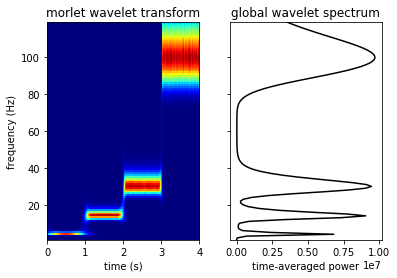

In [31]:
plot_cwt(tt, freq_edited, c_edited, g_edited)

A comparison of global wavelet spectrum for existing output by frequency and edited function correcting for bias shows they are exactly the same:

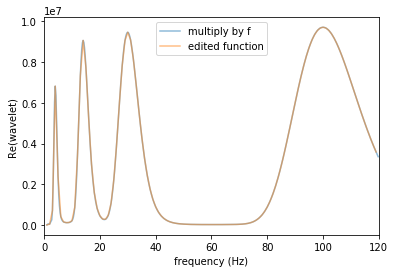

In [32]:
plt.plot(freqr, gr, '-', alpha=0.5, label='multiply by f')
plt.plot(freq_edited, g_edited, '-', alpha=0.5, label='edited function')
plt.ylabel('Re(wavelet)')
plt.xlabel('frequency (Hz)')
plt.xlim(0,120)
plt.legend(loc='best');